# Geospatial Analysis: Arrest Hotspots
**Data Source:** JABookings CSV logs (Dec 2025 - Jan 2026).

This notebook analyzes the `Address1` field to extract Zip Codes and identify geographic concentrations of arrests.

**Key Questions:**
1.  **Hotspots:** Which Zip Codes have the highest number of bookings?
2.  **Homeless vs. Residential:** Do arrests of homeless individuals cluster in specific areas compared to housed individuals?

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

## 1. Data Loading & Parsing
Extracting Zip Codes from `Address1`.

In [2]:
files = sorted(glob.glob("JABookings_*.csv"))
print(f"Found {len(files)} booking files.")

dfs = []
for f in files:
    try:
        df = pd.read_csv(f)
        dfs.append(df)
    except Exception as e:
        print(f"Error reading {f}: {e}")

if dfs:
    data = pd.concat(dfs, ignore_index=True)
    # Deduplicate unique booking events
    data = data.drop_duplicates(subset=['SONumber', 'CaseNumber', 'ConfineDate'])
    
    # Extract Zip Code (5 digits at the end of the string usually)
    # Regex: Look for 5 digits, possibly followed by -xxxx, at the end or near end
    data['ZipCode'] = data['Address1'].astype(str).str.extract(r'(\d{5})')
    
    # Identify Homeless
    data['IsHomeless'] = data['Address1'].astype(str).str.contains('HOMELESS', case=False, na=False)
    
    print(f"Total Records: {len(data)}")
    print(f"Records with valid Zip Code: {data['ZipCode'].notna().sum()}")
else:
    data = pd.DataFrame()
    print("No data loaded.")

Found 30 booking files.
Total Records: 5824
Records with valid Zip Code: 5440


## 2. Top Arrest Locations (Overall)
The Zip Codes with the highest volume of arrestees.

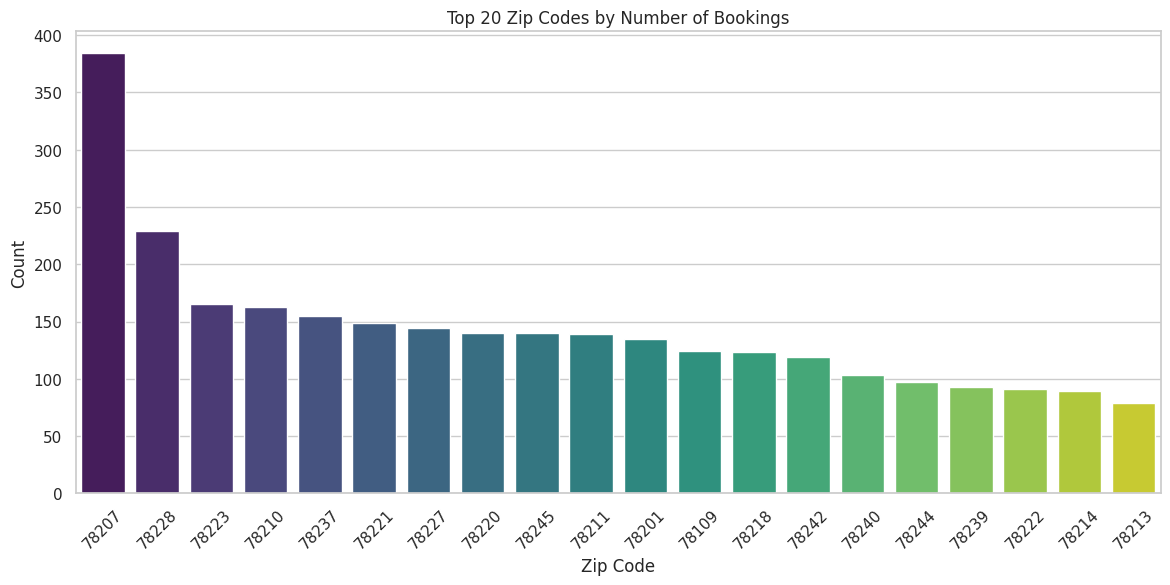

In [3]:
top_zips = data['ZipCode'].value_counts().head(20)

plt.figure(figsize=(14, 6))
sns.barplot(x=top_zips.index, y=top_zips.values, hue=top_zips.index, legend=False, palette='viridis')
plt.title('Top 20 Zip Codes by Number of Bookings')
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## 3. Geographic Disparity: Homeless vs. Housed
Where are homeless individuals being arrested vs. where do housed arrestees live/offend?
*Note: For housed individuals, the address is likely their residence. For homeless, it might be the arrest location or a shelter address.*

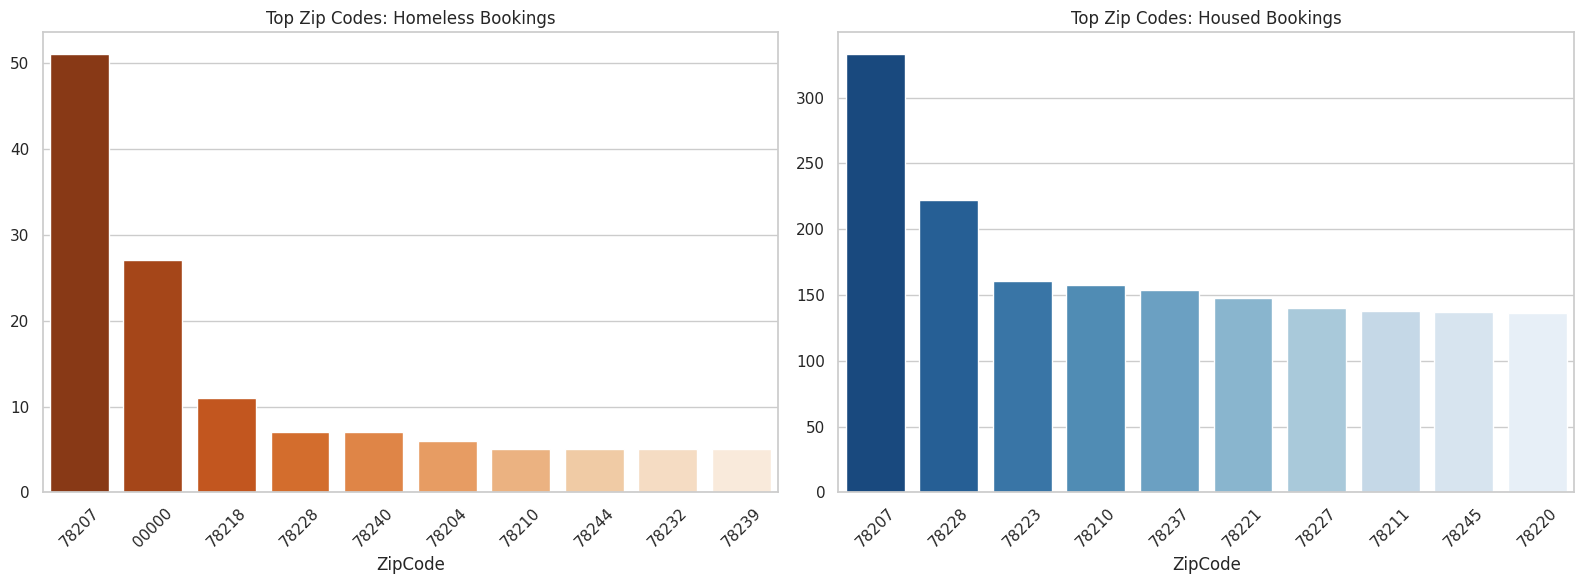

In [4]:
# Top Zips for Homeless
top_zips_homeless = data[data['IsHomeless']]['ZipCode'].value_counts().head(10)

# Top Zips for Housed
top_zips_housed = data[~data['IsHomeless']]['ZipCode'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=top_zips_homeless.index, y=top_zips_homeless.values, ax=axes[0], hue=top_zips_homeless.index, legend=False, palette='Oranges_r')
axes[0].set_title('Top Zip Codes: Homeless Bookings')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x=top_zips_housed.index, y=top_zips_housed.values, ax=axes[1], hue=top_zips_housed.index, legend=False, palette='Blues_r')
axes[1].set_title('Top Zip Codes: Housed Bookings')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Offense Profile by Top Zip Code
What is the most common crime in the #1 Zip Code?

--- Analysis for Zip Code: 78207 ---
Total Bookings: 384
Homeless Bookings: 51 (13.3%)

Most Common Offenses:
ChargeOffenseDescription
POSS CS PG 1/1-B <1G                          45
CRIMINAL TRESPASS                             26
POSS CS PG 1/1-B >=1G<4G                      16
ASSAULT CAUSES BODILY INJURY FAMILY MEMBER    15
POSS MARIJ < 2OZ                              10
THEFT PROP <$2,500 2/MORE PREV CONV           10
DRIVING WHILE INTOXICATED                     10
AGG ASSLT W/DEADLY WEAPON                      9
EVADING ARREST DETENTION                       9
PAROLE VIOLATION                               9
Name: count, dtype: int64


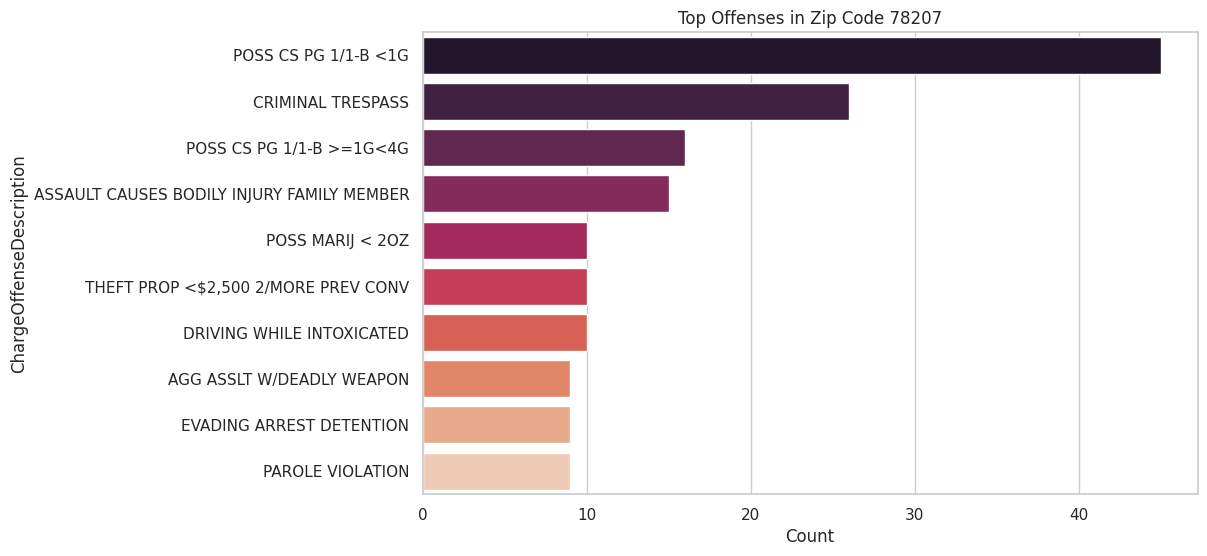

Enter a Zip Code to analyze (or press Enter to skip):  78248


--- Analysis for Zip Code: 78248 ---
Total Bookings: 6
Homeless Bookings: 0 (0.0%)

Most Common Offenses:
ChargeOffenseDescription
DRIVING WHILE INTOXICATED 2ND                     1
ASSAULT CAUSES BODILY INJ                         1
CRIMINAL TRESPASS                                 1
DRIVING WHILE INTOXICATED                         1
ASSAULT CAUSES BODILY INJURY FAMILY MEMBER        1
PUBLISH/THREAT TO PUBLISH INTIMATE VISUAL MATR    1
Name: count, dtype: int64


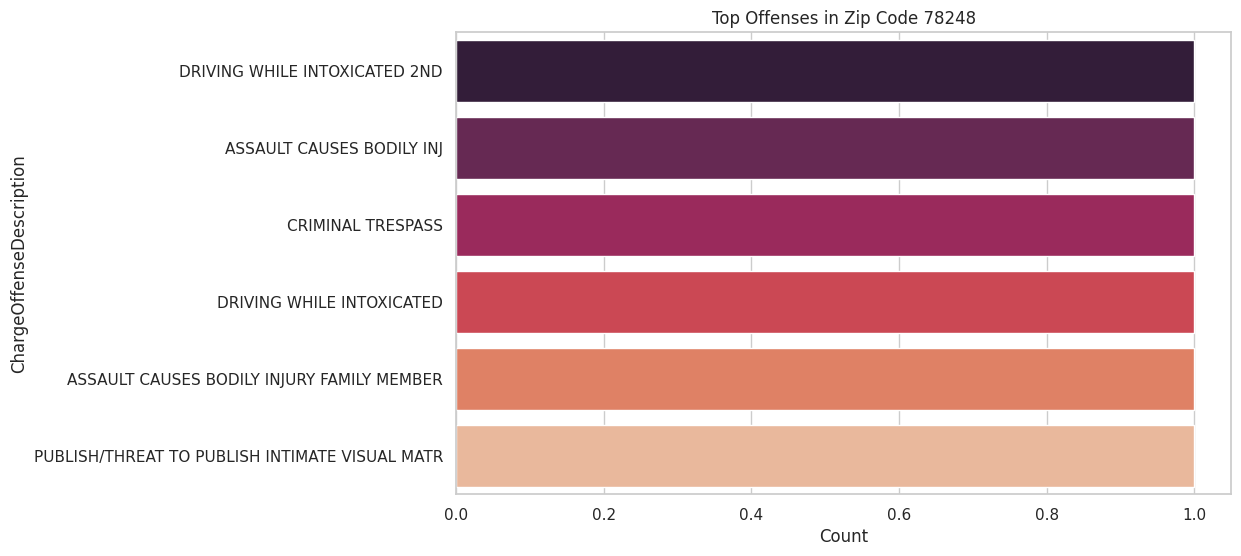

In [8]:
def analyze_zip_code(target_zip):
    target_zip = str(target_zip)
    zip_data = data[data['ZipCode'] == target_zip]
    
    if zip_data.empty:
        print(f"No data found for Zip Code: {target_zip}")
        return
        
    print(f"--- Analysis for Zip Code: {target_zip} ---")
    print(f"Total Bookings: {len(zip_data)}")
    print(f"Homeless Bookings: {zip_data['IsHomeless'].sum()} ({zip_data['IsHomeless'].mean()*100:.1f}%)")
    
    top_crimes = zip_data['ChargeOffenseDescription'].value_counts().head(10)
    print("\nMost Common Offenses:")
    print(top_crimes)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_crimes.index, x=top_crimes.values, hue=top_crimes.index, legend=False, palette='rocket')
    plt.title(f'Top Offenses in Zip Code {target_zip}')
    plt.xlabel('Count')
    plt.show()

# Interactive usage: Change the zip code below to analyze a different area
if not top_zips.empty:
    default_zip = top_zips.index[0]
    analyze_zip_code(default_zip)
    
    # Uncomment the lines below to enable interactive input in Jupyter:
    user_zip = input("Enter a Zip Code to analyze (or press Enter to skip): ")
    if user_zip.strip():
       analyze_zip_code(user_zip.strip())